## ZAKARIA SHAIK
## 22BAI1102

In [ ]:
import numpy as np 
import pandas as pd 
import os
import gc
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm


AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
TRAIN_PATH = '../input/aptos2019-blindness-detection/train_images/'
DF_TRAIN = pd.read_csv('../input/aptos2019-blindness-detection/train.csv', dtype='str')
DF_TRAIN['image_path'] = TRAIN_PATH + DF_TRAIN["id_code"] + ".png" 
DF_TRAIN.head()

,id_code,diagnosis,image_path
0,000c1434d8d7,2,../input/aptos2019-blindness-detection/train_i...
1,001639a390f0,4,../input/aptos2019-blindness-detection/train_i...
2,0024cdab0c1e,1,../input/aptos2019-blindness-detection/train_i...
3,002c21358ce6,0,../input/aptos2019-blindness-detection/train_i...
4,005b95c28852,0,../input/aptos2019-blindness-detection/train_i...


In [3]:
classes = {0 : "No DR",
           1 : "Mild",
           2 : "Moderate",
           3 : "Severe",
           4 : "Proliferative"}

In [4]:
!mkdir ./train_imgs_reshaped

In [5]:
DF_TRAIN['image_path'][0]

'../input/aptos2019-blindness-detection/train_images/000c1434d8d7.png'

In [6]:
'../input/aptos2019-blindness-detection/train_images/000c1434d8d7.png'.split('/')[-1]

'000c1434d8d7.png'

In [7]:
from PIL import Image

for img in DF_TRAIN['image_path']:
    img_outfpath = "./train_imgs_reshaped/" + img.split('/')[-1]
    image = Image.open(img)
    image = image.resize((512,512),Image.ANTIALIAS)
    image.save(fp=img_outfpath)

In [8]:
TRAIN_PATH_RS = './train_imgs_reshaped/'
DF_TRAIN_RS = pd.read_csv('../input/aptos2019-blindness-detection/train.csv', dtype='str')
DF_TRAIN_RS['image_path'] = TRAIN_PATH_RS + DF_TRAIN_RS["id_code"] + ".png" 
DF_TRAIN_RS.head()

,id_code,diagnosis,image_path
0,000c1434d8d7,2,./train_imgs_reshaped/000c1434d8d7.png
1,001639a390f0,4,./train_imgs_reshaped/001639a390f0.png
2,0024cdab0c1e,1,./train_imgs_reshaped/0024cdab0c1e.png
3,002c21358ce6,0,./train_imgs_reshaped/002c21358ce6.png
4,005b95c28852,0,./train_imgs_reshaped/005b95c28852.png


In [ ]:
def encode_and_bind(original_dataframe, feature_to_encode):
    dummies = pd.get_dummies(original_dataframe[[feature_to_encode]])
    res = pd.concat([original_dataframe, dummies], axis=1)
    res = res.drop([feature_to_encode], axis=1)
    return(res) 

In [10]:
res = encode_and_bind(DF_TRAIN_RS, 'diagnosis')

In [11]:
res.head()

,id_code,image_path,diagnosis_0,diagnosis_1,diagnosis_2,diagnosis_3,diagnosis_4
0,000c1434d8d7,./train_imgs_reshaped/000c1434d8d7.png,0,0,1,0,0
1,001639a390f0,./train_imgs_reshaped/001639a390f0.png,0,0,0,0,1
2,0024cdab0c1e,./train_imgs_reshaped/0024cdab0c1e.png,0,1,0,0,0
3,002c21358ce6,./train_imgs_reshaped/002c21358ce6.png,1,0,0,0,0
4,005b95c28852,./train_imgs_reshaped/005b95c28852.png,1,0,0,0,0


In [12]:
classes = {"diagnosis_0" : "No DR",
           "diagnosis_1" : "Mild",
           "diagnosis_2" : "Moderate",
           "diagnosis_3" : "Severe",
           "diagnosis_4" : "Proliferative"}

In [13]:
res.rename(columns=classes, inplace=True)
res.head()

,id_code,image_path,No DR,Mild,Moderate,Severe,Proliferative
0,000c1434d8d7,./train_imgs_reshaped/000c1434d8d7.png,0,0,1,0,0
1,001639a390f0,./train_imgs_reshaped/001639a390f0.png,0,0,0,0,1
2,0024cdab0c1e,./train_imgs_reshaped/0024cdab0c1e.png,0,1,0,0,0
3,002c21358ce6,./train_imgs_reshaped/002c21358ce6.png,1,0,0,0,0
4,005b95c28852,./train_imgs_reshaped/005b95c28852.png,1,0,0,0,0


In [14]:
res.columns

Index(['id_code', 'image_path', 'No DR', 'Mild', 'Moderate', 'Severe',
       'Proliferative'],
      dtype='object')

In [15]:
target = np.array(res[['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative']])

In [16]:
X_train, X_test, y_train, y_test  = train_test_split(res['image_path'], target, test_size=0.33, random_state=42)
print(f"train shape: {X_train.shape}- y_train shape: {y_train.shape}")
print(f"test shape: {X_test.shape}- y_test shape: {y_test.shape}")

train shape: (2453,)- y_train shape: (2453, 5)
test shape: (1209,)- y_test shape: (1209, 5)


(-0.5, 511.5, 511.5, -0.5)

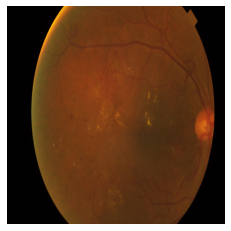

In [17]:
from PIL import Image
image_path = Image.open('./train_imgs_reshaped/000c1434d8d7.png')
plt.imshow(image_path)
plt.axis("off")

In [ ]:
num_classes = 5
input_shape = (512, 512, 3)
learning_rate = 1e-4 
weight_decay = 0.0001
batch_size = 16 
num_epochs = 100
image_size =  256 
patch_size = 7 
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  
transformer_layers = 8
mlp_head_units = [56, 28]  

In [19]:
num_patches

1296

In [20]:
@tf.function
def load(image_file, target):
    image = tf.io.read_file(image_file)
    image = tf.image.decode_png(image)

    image_ = tf.cast(image, tf.uint8)
    return image, target

In [21]:
train_loader = (
    tf.data.Dataset
    .from_tensor_slices((X_train,y_train))
    .map(load, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(batch_size)
)
test_loader = (
    tf.data.Dataset
    .from_tensor_slices((X_test,y_test))
    .map(load, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(batch_size)
)

In [ ]:
train_batch = (
    tf.data.Dataset
    .from_tensor_slices((X_train,y_train))
    .map(load, num_parallel_calls=AUTOTUNE)
    .shuffle(7)
    .batch(X_train.shape[0]-100)
)


In [ ]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.Normalization(),
        layers.experimental.preprocessing.Resizing(image_size, image_size),
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(factor=0.02),
        layers.experimental.preprocessing.RandomZoom(
            height_factor = 0.2, width_factor = 0.2
        ),
    ],
     name="data_augmentation",
)
CompleteBatchData  =next(iter(train_batch))[0]
data_augmentation.layers[0].adapt(CompleteBatchData)

In [24]:
del CompleteBatchData
gc.collect()

2941

In [25]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation = tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

In [ ]:
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        
    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images = images,
            sizes = [1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding="VALID",
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

(1, 256, 256, 3)
Image size: 256 X 256
Patch size: 7 X 7
Patches per image: 1296
Elements per patch: 147


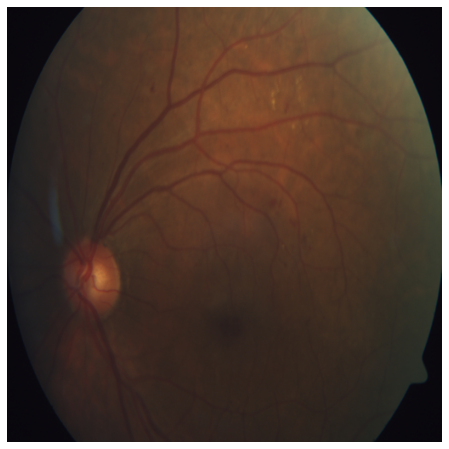

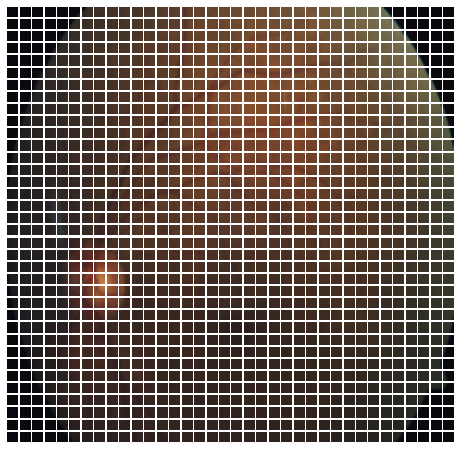

In [ ]:
plt.figure(figsize=(8, 8))
image = next(iter(train_loader))[0][5]

plt.imshow(image)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([image]), size=(image_size, image_size)
)

print(resized_image.shape)
patches = Patches(patch_size)(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))

plt.figure(figsize=(8, 8))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(patch_img.numpy().astype('uint8'))
    plt.axis("off")

In [29]:
class PatchEncoder(layers.Layer):
    def __init__(self, num_of_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units = projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim = num_patches, output_dim = projection_dim
        )
        
    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encode = self.projection(patch) + self.position_embedding(positions)
        return encode

In [ ]:
def vit_model():
    inputs = layers.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    patches = Patches(patch_size)(augmented)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = layers.BatchNormalization()(encoded_patches)
        # create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.BatchNormalization()(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        encoded_patches = layers.Add()([x3, x2])
    
    representation = layers.LayerNormalization()(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units = mlp_head_units, dropout_rate=0.5)
    logits = layers.Dense(num_classes, activation='softmax')(features)
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

In [31]:
def experiment(model):
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay
    )
    
    model.compile(
        optimizer=optimizer,
        loss=keras.losses.CategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.CategoricalAccuracy(name="accuracy"),
            keras.metrics.AUC( name="AUC"),
        ],
     )
    checkpoint_filepath = "./tmp/checkpoint"
    checkpoint_callback = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,
    )

    history = model.fit(train_loader ,
                        batch_size=batch_size,
                        epochs=num_epochs,
                        validation_data=test_loader,
                        callbacks=[checkpoint_callback],)
    model.load_weights(checkpoint_filepath)
    _, accuracy, auc = model.evaluate(test_loader)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test AUC: {round(auc * 100, 2)}%")

    return history

In [32]:
vit_classifier = vit_model()
vit_classifier.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 512, 3) 0                                            
__________________________________________________________________________________________________
data_augmentation (Sequential)  (None, 256, 256, 3)  7           input_1[0][0]                    
__________________________________________________________________________________________________
patches_2 (Patches)             (None, None, 147)    0           data_augmentation[0][0]          
__________________________________________________________________________________________________
patch_encoder (PatchEncoder)    (None, 1296, 64)     92416       patches_2[0][0]                  
______________________________________________________________________________________________

In [33]:
history = experiment(vit_classifier)

Epoch 1/100
154/154 [==============================] - 113s 652ms/step - loss: 2.3076 - accuracy: 0.2702 - AUC: 0.5614 - val_loss: 1.5625 - val_accuracy: 0.3838 - val_AUC: 0.7563
Epoch 2/100
154/154 [==============================] - 97s 630ms/step - loss: 1.5437 - accuracy: 0.4033 - AUC: 0.7183 - val_loss: 1.2052 - val_accuracy: 0.5029 - val_AUC: 0.8414
Epoch 3/100
154/154 [==============================] - 97s 633ms/step - loss: 1.4896 - accuracy: 0.4249 - AUC: 0.7370 - val_loss: 1.1441 - val_accuracy: 0.4897 - val_AUC: 0.8403
Epoch 4/100
154/154 [==============================] - 98s 634ms/step - loss: 1.4372 - accuracy: 0.4438 - AUC: 0.7512 - val_loss: 1.1340 - val_accuracy: 0.4888 - val_AUC: 0.8436
Epoch 5/100
154/154 [==============================] - 98s 634ms/step - loss: 1.3883 - accuracy: 0.4428 - AUC: 0.7637 - val_loss: 1.1532 - val_accuracy: 0.4888 - val_AUC: 0.8407
Epoch 6/100
154/154 [==============================] - 97s 631ms/step - loss: 1.3872 - accuracy: 0.4608 - AUC

dict_keys(['loss', 'accuracy', 'AUC', 'val_loss', 'val_accuracy', 'val_AUC'])


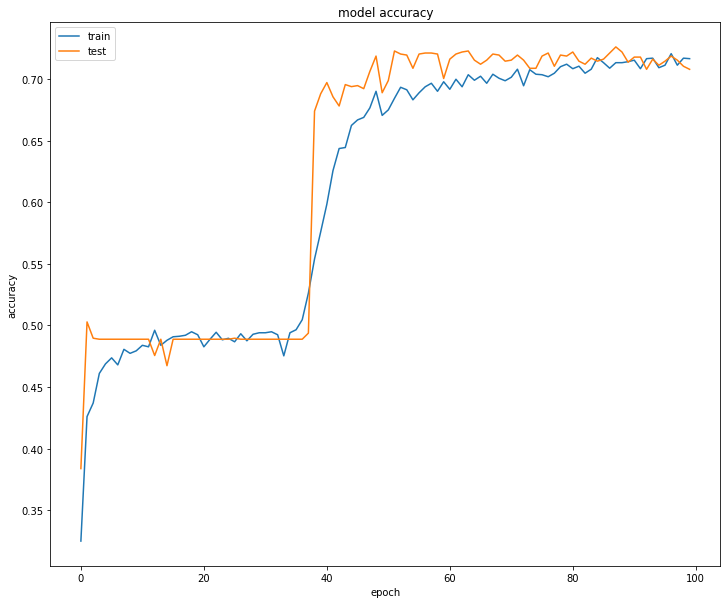

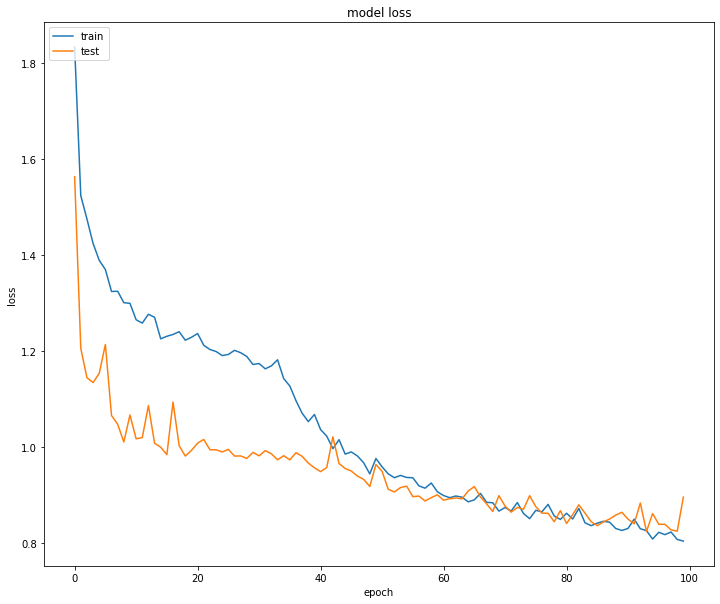

In [ ]:

print(history.history.keys())

plt.figure(figsize=(12,10))
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.figure(figsize=(12,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

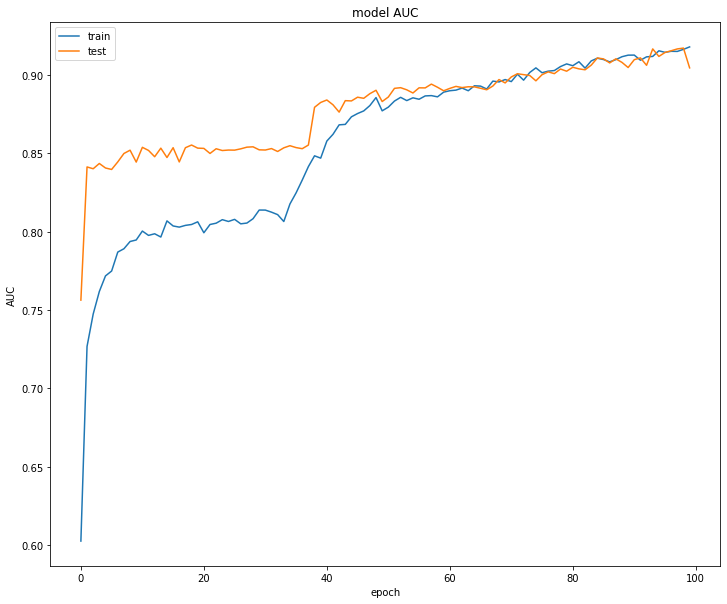

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('model AUC')
plt.ylabel('AUC')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [36]:
vit_classifier.load_weights("./tmp/checkpoint")

In [ ]:
def get_img_array(img):

    array = keras.preprocessing.image.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

In [ ]:
def gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):

    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(last_conv_layer_name).output,  model.output]
    )
    
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]
        
    grads = tape.gradient(class_channel, last_conv_layer_output)

    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    last_conv_layer_output = last_conv_layer_output
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [39]:
classes.values()

dict_values(['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'])

In [ ]:
def display_gradcam(img, heatmap, cam_path="cam.jpg", alpha=0.4, preds=[0,0,0,0,0], plot=None):

    heatmap = np.uint8(255 * heatmap)

    jet = cm.get_cmap("jet")

    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    jet_heatmap = keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.preprocessing.image.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.preprocessing.image.array_to_img(superimposed_img)

    plot.imshow(superimposed_img)
    plot.set(title =
        " No DR: \
        {:.3f}\nMild: \
        {:.3f}\nModerate: \
        {:.3f}\nSevere: \
        {:.3f}\nProliferative: \
        {:.3f}".format(preds[0], \
                    preds[1], \
                    preds[2], \
                    preds[3],
                    preds[4])
    )
    plot.axis('off')

In [ ]:
np.sqrt(1296)

36.0

Predicted:
No DR:     5.2479400634765625
Mild: -2.3091275691986084
Moderate:     -1.5259379148483276
Severe:     -6.3340349197387695
Proliferative: -4.788928031921387


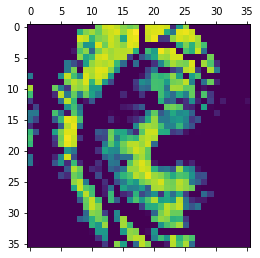

In [ ]:
test_image = next(iter(test_loader))[0][5]
img_array =get_img_array(test_image)
last_conv_layer_name = 'layer_normalization'
vit_classifier.layers[-1].activation = None
preds = vit_classifier.predict(img_array)
print("Predicted:\n" + "No DR: \
    {p1}\nMild: {p2}\nModerate: \
    {p3}\nSevere: \
    {p4}\nProliferative: {p5}".format(p1=preds[0][0], 
p2=preds[0][1],p3=preds[0][2],p4=preds[0][3],p5=preds[0][4]))
heatmap = gradcam_heatmap(img_array, vit_classifier, last_conv_layer_name)

heatmap = np.reshape(heatmap, (36,36))
plt.matshow(heatmap)

plt.show()

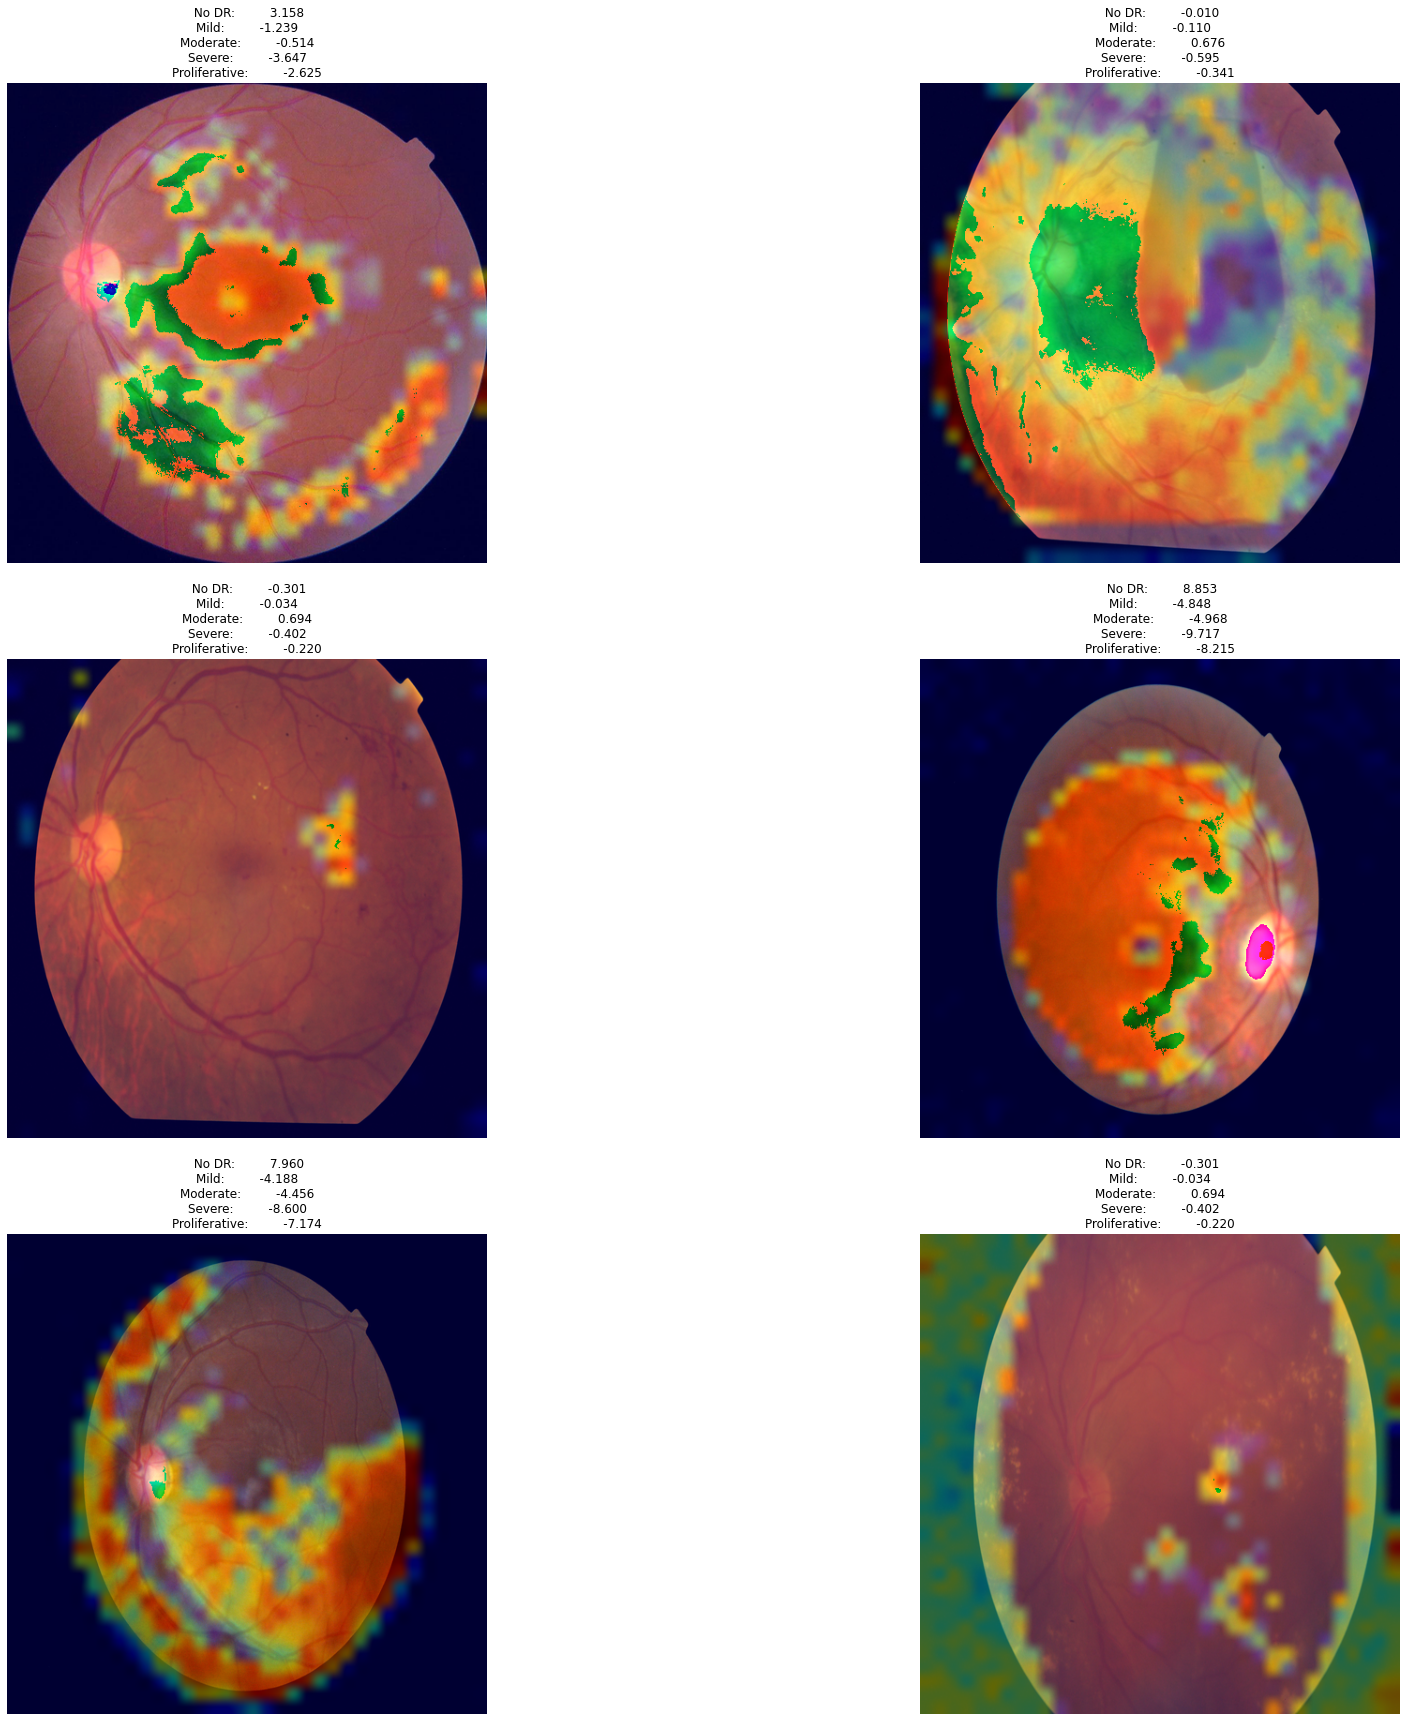

In [ ]:
fig, axis = plt.subplots(3, 2, figsize=(30, 30))
for images, ax in zip(next(iter(test_loader))[0][:6], axis.flat):
    img_array = get_img_array(images)
    vit_classifier.layers[-1].activation = None
    preds = vit_classifier.predict(img_array)
    heatmap = gradcam_heatmap(img_array, vit_classifier, last_conv_layer_name)
    heatmap = np.reshape(heatmap, (36,36))
    display_gradcam(images, heatmap, preds=preds[0], plot=ax)